![](http://campbelllawobserver.com/wp-content/uploads/2019/04/20180525_canada-cannabis_master_2000-620x375.jpg)

# <center> Health Canada Cannabis Web Scraping

**Team members:**
- Pep Ruckpanich
- Sikiru Akadiri
- Mehdi Rahiminejad

In [57]:
# import the necessary libraries
from bs4 import BeautifulSoup
import requests
from time import sleep
from collections import Counter
import pandas as pd
from difflib import SequenceMatcher
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### A. Making a Request

In [58]:
# URL addrress of the website is going to be scrapped
page_url = 'https://www.canada.ca/en/health-canada/services/drugs-medication/cannabis/industry-licensees-applicants/licensed-cultivators-processors-sellers.html'

In [59]:
request_result = requests.get(page_url)

if request_result.status_code == 200:
    print('The web request was done successfully!')
else:
    print(f'Somthings is wrong with the web request. Check this status code: {request_result.status_code}')

The web request was done successfully!


### B. Getting Page Content

In [60]:
page_content_soup = BeautifulSoup(request_result.content,'lxml')

### C. Scraping Website and extracting Data

In [61]:
# selecting the table
data_table = page_content_soup.find('table',class_='wb-tables')

In [62]:
#select the header of the table
table_head = data_table.find('thead')

In [63]:
# select the body of the table
table_body = data_table.find('tbody')

In [64]:
## find header
#header_ids = ['t1ch1', 't1ch2','t1ch3','t1ch7','t1ch8','t1ch5','t1ch6','t1ch4']
#t_labels = []
#for i in header_ids:
#    t_labels.append(table_head.find(id=i).get_text())
#t_labels

In [65]:

# define local functions
def clean_data(in_data):
    '''
    This function removes all space, "\n", and "\xa0" characters from the left and right sides of each string.
    '''
    if(type(in_data)==str):
        return in_data.strip(' \n\xa0')
    elif(type(in_data)==list):
        new_list=[]
        for x in in_data:
            new_list.append(x.strip(' \n\xa0'))
        return new_list   


def label_exists(in_str, in_list, sim_ratio=0.85):
    '''
    This function check if the input string (in_str) has similarity more than sim_ratio percentage to any elements in 
    the input list (in_list).
    
    in_str: string value that is going to be checked its similarity
    in_list: list od string
    sim_ratio: minimum similarity ratio. It is optional and its default value is 0.85
    '''
    if not (0<=sim_ratio<=1):
        print('Error: similarity ratio must be beween 0 and 1')
        return
    
    result_value = False
    
    for item in in_list:
        dist = SequenceMatcher(None, in_str.replace(' ',''), item.replace(' ','')).ratio()
        if dist > sim_ratio:
            result_value = True
            break
    
    return result_value



def get_licence_holder_info(row_data):
    '''
    This function gets a row of the read table and returns a ditionary that can be added to the licence_holder dataframe
    '''
    licence_holder_dic = {}
    licence_holder_dic['licence holder'] = clean_data(row_data[0].get_text())
    licence_holder_dic['province / territory'] = clean_data(row_data[1].get_text())
    licence_holder_dic['phone numbers'] = clean_data(row_data[5].get_text())
    licence_holder_dic['date of initial licensing'] = clean_data(row_data[6].get_text())
    
    return licence_holder_dic


def get_info(holder, available_labels, dataframe):
    '''
    This function gets row data of the read table and returns a ditionary that can be added to dataframe
    '''
    result_dic = {}
    result_dic['licence holder'] = holder
    for k in dataframe.columns[1:]:
        if label_exists(k, available_labels):
            result_dic[k] = 1
        else:
            result_dic[k] = 0
    
    return result_dic


def update_dataframe_columns(df, data):
    '''
    This function gets a data list and a dataframe. If data list contains a vlaue which is not available in the 
    df datarfame, a new culomn will be added
    '''
    for d in data:
        if not(label_exists(d, ['N/A']) or label_exists(d, df.columns) or d==''):
            #create a new column in df
            df[d] = [0]*len(df)
    
    return df

In [66]:
# defining 4 dataframes to collect data from the table body. Except the 1st pne, the rest are dynamic and columns will be added later
licence_holders_df = pd.DataFrame(columns=['licence holder','province / territory','phone numbers','date of initial licensing'])
licences_df = pd.DataFrame(columns=['licence holder'])
retailers_df = pd.DataFrame(columns=['licence holder'])
patients_df = pd.DataFrame(columns=['licence holder'])

In [67]:
# a loop to go over all rows of the table body and transfer data to the data frames
for row in table_body.find_all('tr'):
    row_data = row.find_all('td')
    
    # update licence_holders_df dataframe
    licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
    
    current_licences = clean_data(row_data[2].get_text().split('\n'))
    current_holder = clean_data(row_data[0].get_text())
    #add new columns to licences_df dataframe if necessary
    licences_df = update_dataframe_columns(licences_df, current_licences)
    # update licences dataframe
    temp_dic = get_info(current_holder, current_licences, licences_df)
    licences_df = licences_df.append(temp_dic, ignore_index = True)            

    current_retailers = clean_data(row_data[3].get_text().split('\n'))
    #add new columns to retailers_df dataframe if necessary
    retailers_df = update_dataframe_columns(retailers_df, current_retailers)
    # update classes_sell_to_retailers dataframe
    temp_dic = get_info(current_holder, current_retailers, retailers_df)
    retailers_df = retailers_df.append(temp_dic, ignore_index = True)            

    current_patients = clean_data(row_data[4].get_text().split('\n'))
    #add new columns to patients_df dataframe if necessary
    patients_df = update_dataframe_columns(patients_df, current_patients)
    # update classes_sell_to_retailers dataframe
    temp_dic = get_info(current_holder, current_patients, patients_df)
    patients_df = patients_df.append(temp_dic, ignore_index = True)            
    
        

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instea

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  patients_df = patients_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licence_holders_df = licence_holders_df.append(get_licence_holder_info(row_data), ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  licences_df = licences_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  retailers_df = retailers_df.append(temp_dic, ignore_index = True)
C:\Users\sikir\AppData\Local\Temp\ipykernel_15236\4013575196.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

### D. Clean the Dataframes Manually

In [68]:
# It was observed that in some rows of the table, 'PE' province was typed as 'PEI'
for row in np.where(licence_holders_df['province / territory']=='PEI')[0]:
    licence_holders_df.loc[row]['province / territory']='PE'

In [69]:


# It was observed that in some rows of the table, 'Fresh / Dried' was entered insted of 'Dried / Fresh'
retailers_df['Dried / Fresh'] += retailers_df['Fresh / Dried']
retailers_df.drop(columns='Fresh / Dried');



### E. Extracting Required Info

#### E.1. How many licensed cannabis companies exist in Canada

In [71]:
len(licence_holders_df['licence holder'].unique())

893

#### E.2. What type of cannabis license does each company have

In [72]:
#This information is already ready in "licences_df". The question is how we can show it.

In [73]:
merged_licences_df = licences_df.merge(licence_holders_df, on = 'licence holder')
merged_licences_df.head(10)

,licence holder,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST,province / territory,phone numbers,date of initial licensing
0,CROW FOOT CANNABIS INC.,1.0,0,0,0,0,0,0,BC,N/A,2022-08-12
1,Herbanova inc.,0.0,1,0,0,0,0,0,QC,N/A,2022-08-05
2,Micro-culture du Saguenay Inc.,1.0,0,0,0,0,0,0,QC,N/A,2022-08-05
3,Mari-Sag Inc,1.0,0,0,0,0,0,0,QC,N/A,2022-08-05
4,Jean Landry,1.0,0,0,0,0,0,0,QC,N/A,2022-07-29
5,1335214 B.C. LTD.,0.0,0,1,0,0,0,0,BC,N/A,2022-07-29
6,WestQuebec Growers Inc.,0.0,1,0,0,0,0,0,QC,N/A,2022-07-29
7,Brantford Micro-Grow Inc.,1.0,0,0,1,0,0,0,ON,N/A,2022-07-29
8,11997459 CANADA INC. d.b.a. Irie Craft Cannabis,0.0,1,0,0,1,1,0,ON,N/A,2022-07-29
9,Les Plantations HighGreens Inc.,1.0,0,0,0,0,0,0,QC,N/A,2022-07-29



#### E.3. Who can legally sell to medical cannabis patients

In [74]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'Sale (Medical)']
legally_sell_medical = merged_licences_df[merged_licences_df['Sale (Medical)']==1][columns]
legally_sell_medical.sort_values('province / territory')

,licence holder,province / territory,phone numbers,Sale (Medical)
903,Simply Solventless Concentrates Ltd.,AB,1-833-772-4274,1
751,Pure Life Cannabis Corp.,AB,780-884-9782,1
759,Radient Technologies (Cannabis) Inc.,AB,N/A,1
376,Total Cannabis Solutions Inc.,AB,1-844-989-8274,1
367,BATTLE RIVER PHARMACEUTICALS INC.,AB,403-398-9818,1
...,...,...,...,...
808,102021671 Saskatchewan Inc.,SK,N/A,1
841,Zyus Life Sciences Inc.,SK,1-833-713-CARE (2273),1
622,ENDLESS SKY INC.,SK,403-978-3965,1
737,OneLeaf Cannabis Corp.,SK,N/A,1


#### E.4. Who has gotten their license revoked

In [75]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'REVOKED ON REQUEST']
revoked_licence = merged_licences_df[merged_licences_df['REVOKED ON REQUEST']==1][columns]
revoked_licence.sort_values('province / territory')

,licence holder,province / territory,phone numbers,REVOKED ON REQUEST
542,Alberta Altitude Organics LTD.,AB,N/A,1
340,Daniel Lloyd Paul,BC,N/A,1
343,Gladde & Reel's Garden,NS,N/A,1
687,Auxly Annapolis Inc.,NS,N/A,1
498,Tweed Inc. (4th site),ON,N/A,1
649,GROWPROS MMP INC.,QC,N/A,1
655,HEXO,QC,N/A,1
268,Borealis Farm Ltd.,SK,N/A,1


#### E.5. What licenses have been issued over time (cumulative). What are the most trending licenses

In [76]:
new_df = merged_licences_df.groupby(merged_licences_df['province / territory']).sum()

In [77]:
new_df

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
province / territory,,,,,,,
AB,32.0,42,6,20,45,53,1
BC,65.0,83,16,22,79,83,1
MB,10.0,3,0,3,5,6,0
NB,10.0,11,1,3,9,10,0
NL,3.0,4,0,3,3,4,0
NS,20.0,10,1,5,12,11,2
NT,0.0,1,0,0,0,1,0
ON,65.0,138,5,30,128,157,1
PE,2.0,2,0,3,2,4,0


In [78]:
new_df['Total']=new_df.sum(axis=1)
new_df = new_df.sort_values('Total')

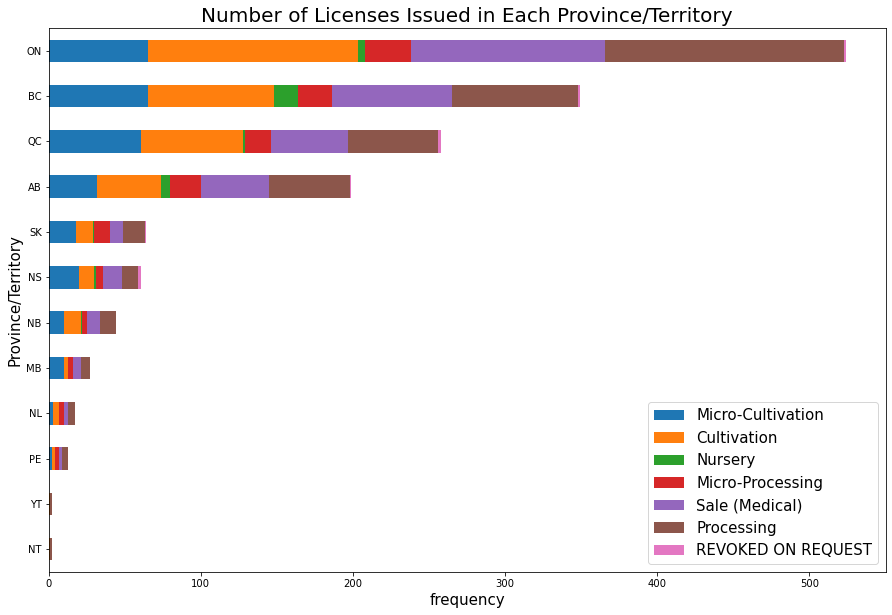

In [79]:
columns = new_df.columns
new_df[columns[:-1]].plot(kind='barh', stacked=True, figsize=(15,10));
plt.xlabel('frequency', fontsize=15);
plt.ylabel('Province/Territory', fontsize=15);
plt.title('Number of Licenses Issued in Each Province/Territory', fontsize=20);
plt.legend(loc='lower right', fontsize=15);

#### E.6. Related to above, which province is trending over time (so something like % of total licenses issued each year breakdown by province)

In [80]:
merged_licences_df['date of initial licensing'] = pd.to_datetime(merged_licences_df['date of initial licensing'])

In [81]:
group_by_columns = [merged_licences_df['province / territory'],merged_licences_df['date of initial licensing'].dt.year]
Province_year_grp = merged_licences_df.groupby(by=group_by_columns).sum()

In [82]:
Province_year_grp

Micro-Cultivation  \
province / territory date of initial licensing                      
AB                   2017                                     0.0   
                     2018                                     0.0   
                     2019                                     0.0   
                     2020                                    11.0   
                     2021                                    10.0   
...                                                           ...   
SK                   2019                                     2.0   
                     2020                                     9.0   
                     2021                                     5.0   
                     2022                                     2.0   
YT                   2021                                     0.0   

                                                Cultivation  Nursery  \
province / territory date of initial licensing                         
AB                   2017                                 2        0   
                     2018                                 5        0   
                     2019                                15        1   
                     2020                                 8        1   
                     2021                                 8        1   
...                                                     ...      ...   
SK                   2019                                 2        1   
                     2020                                 3        0   
                     2021                                 3        0   
                     2022                                 2        0   
YT                   2021                                 1        0   

                                                Micro-Processing  \
province / territory date of initial licensing                     
AB                   2017                                      0   
                     2018                                      0   
                     2019                                      1   
                     2020                                      9   
                     2021                                      7   
...                                                          ...   
SK                   2019                                      2   
                     2020                                      5   
                     2021                                      2   
                     2022                                      1   
YT                   2021                                      0   

                                                Sale (Medical)  Processing  \
province / territory date of initial licensing                               
AB                   2017                                    2           2   
                     2018                                    3           5   
                     2019                                   14          17   
                     2020                                    9          10   
                     2021                                   11          11   
...                                                        ...         ...   
SK                   2019                                    5           4   
                     2020                                    2           4   
                     2021                                    0           3   
                     2022                                    1           2   
YT                   2021                                    0           1   

                                                REVOKED ON REQUEST  
province / territory date of initial licensing                      
AB                   2017                                        0  
                     2018                                        0  
                     2019            

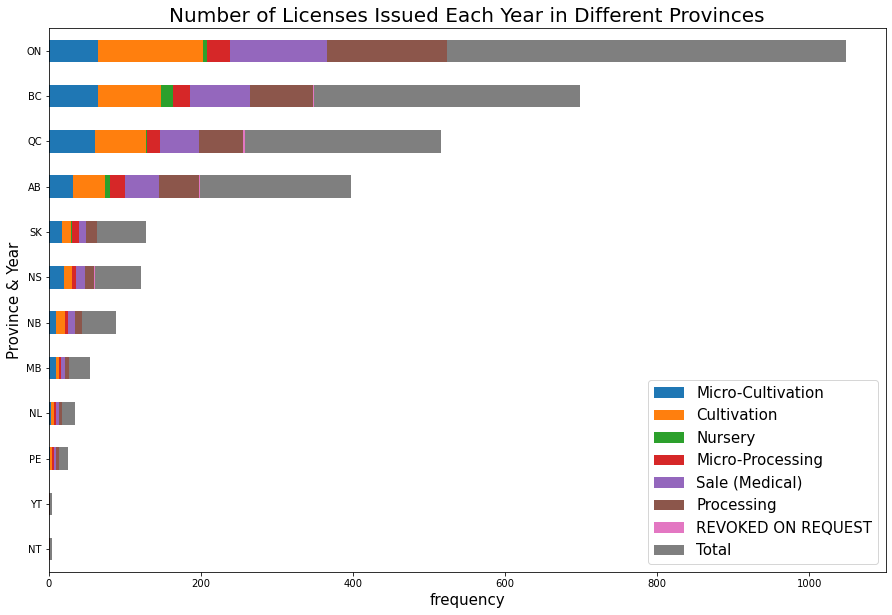

In [83]:
new_df.plot(kind='barh', stacked=True, figsize=(15,10));
plt.xlabel('frequency', fontsize=15);
plt.ylabel('Province & Year', fontsize=15);
plt.title('Number of Licenses Issued Each Year in Different Provinces', fontsize=20);
plt.legend(loc='lower right', fontsize=15);

#### E.7. How about breakdown by East and West region of Canada?

In [84]:
# adding new column to merged_licences_df to show the region based on the following categories:
# West region: MB, SK, AB, BC, YT, and NT
# East region: NB, NL, NS, PE, QC, and ON
west_region = ('MB', 'SK', 'AB', 'BC', 'YT', 'NT')
east_region = ('NB', 'NL', 'NS', 'PE', 'QC', 'ON')
region=['West Region' if p in west_region else 'East Region' for p in merged_licences_df['province / territory']]
merged_licences_df['Region'] = region

In [85]:
group_by_columns = [merged_licences_df['Region'],merged_licences_df['date of initial licensing'].dt.year]
new_df = merged_licences_df.groupby(by=group_by_columns).sum()

In [86]:
new_df

Micro-Cultivation  Cultivation  \
Region      date of initial licensing                                   
East Region 2013                                     0.0            3   
            2014                                     0.0            8   
            2015                                     0.0            1   
            2016                                     0.0            7   
            2017                                     0.0           22   
            2018                                     0.0           25   
            2019                                     6.0           34   
            2020                                    56.0           65   
            2021                                    61.0           45   
            2022                                    38.0           22   
West Region 2014                                     0.0            4   
            2016                                     0.0            2   
            2017                                     0.0           10   
            2018                                     1.0           13   
            2019                                     5.0           37   
            2020                                    51.0           37   
            2021                                    46.0           25   
            2022                                    22.0           13   

                                       Nursery  Micro-Processing  \
Region      date of initial licensing                              
East Region 2013                             0                 0   
            2014                             0                 0   
            2015                             0                 0   
            2016                             0                 0   
            2017                             0                 0   
            2018                             0                 0   
            2019                             0                 5   
            2020                             4                24   
            2021                             3                21   
            2022                             1                11   
West Region 2014                             0                 0   
            2016                             0                 0   
            2017                             0                 0   
            2018                             0                 1   
            2019                             5                 4   
            2020                             5                22   
            2021                             8                18   
            2022                             5                10   

                                       Sale (Medical)  Processing  \
Region      date of initial licensing                               
East Region 2013                                    3           3   
            2014                                    7           8   
            2015                                    1           1   
            2016                                    6           7   
            2017                                   16          20   
            2018                                   17          31   
            2019                                   39          39   
            2020                                   61          68   
            2021                                   35          45   
            2022                                   20          23   
West Region 2014                                    4           4   
            2016                                    2           2   
            2017                                   10          10   
            2018                                    8          12   
            2019                                   32          39   
            2020                            

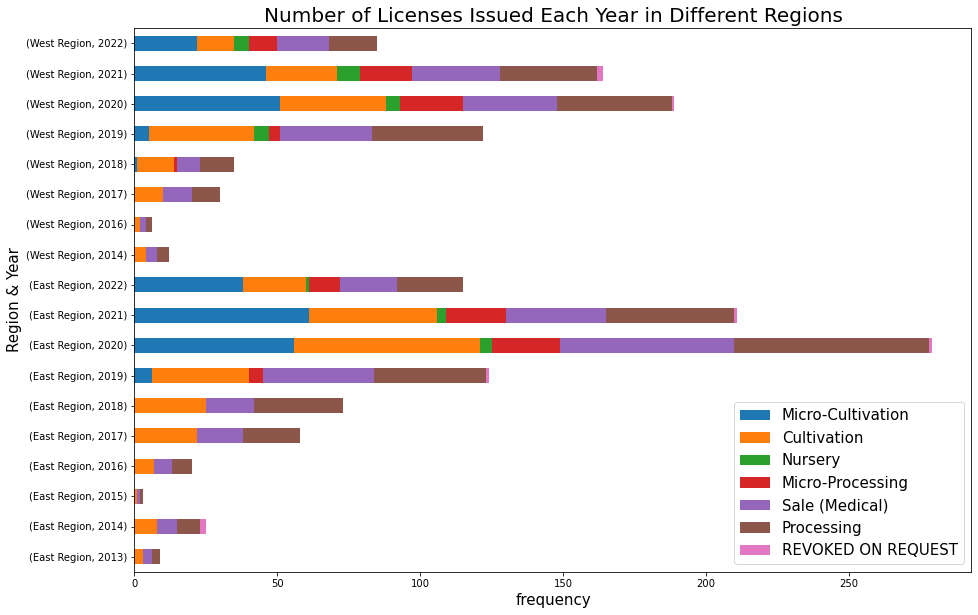

In [87]:
new_df.plot(kind='barh', stacked=True, figsize=(15,10));
plt.xlabel('frequency', fontsize=15);
plt.ylabel('Region & Year', fontsize=15);
plt.title('Number of Licenses Issued Each Year in Different Regions', fontsize=20);
plt.legend(loc='lower right', fontsize=15);

#### E.8. Breakdown of licenses issued each year

In [88]:
group_by_columns = [merged_licences_df['date of initial licensing'].dt.year]
new_df = merged_licences_df.groupby(by=group_by_columns).sum()

In [89]:
new_df

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2013,0.0,3,0,0,3,3,0
2014,0.0,12,0,0,11,12,2
2015,0.0,1,0,0,1,1,0
2016,0.0,9,0,0,8,9,0
2017,0.0,32,0,0,26,30,0
2018,1.0,38,0,1,25,43,0
2019,11.0,71,5,9,71,78,1
2020,107.0,102,9,46,94,108,2
2021,107.0,70,11,39,66,79,3


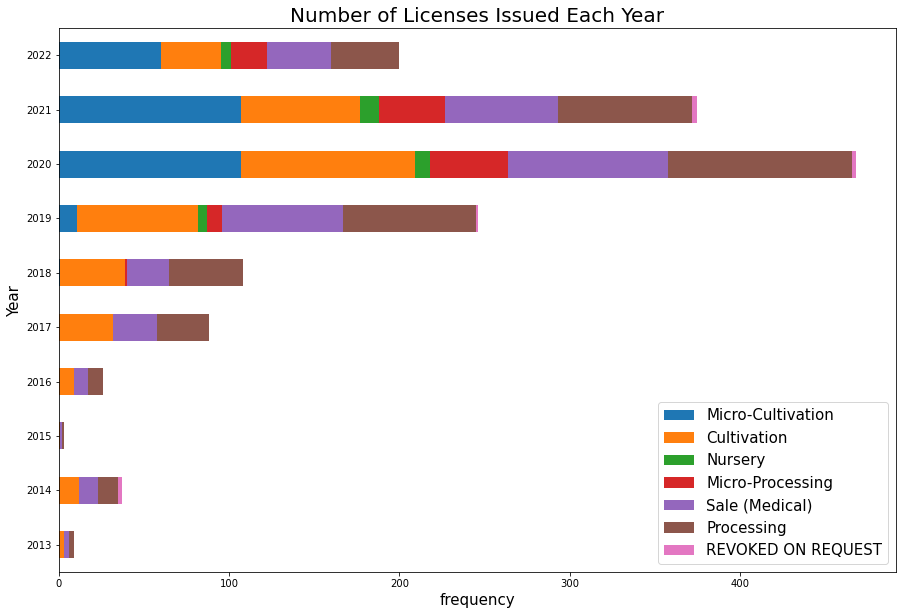

In [90]:
new_df.plot(kind='barh', stacked=True, figsize=(15,10));
plt.xlabel('frequency', fontsize=15);
plt.ylabel('Year', fontsize=15);
plt.title('Number of Licenses Issued Each Year', fontsize=20);
plt.legend(loc='lower right', fontsize=15);

In [91]:
merged_licences_df.groupby(['province / territory','licence holder'])[['licence holder']].count()

licence holder
province / territory licence holder                                                
AB                   10252832 Canada Inc.                                         1
                     12307561 CANADA INC. d.b.a. CANNASHER WELLNESS               1
                     1241936 B.C. LTD.                                            1
                     1800905 Alberta Ltd. d.b.a. sugarbud                         1
                     1998643 Alberta Ltd. DBA Stigma Grow                         1
...                                                                             ...
SK                   Western Cannabis Ltd.                                        1
                     Zevk Cultivation Inc.                                        1
                     Zyus Life Sciences Inc.                                      1
                     dB Thunderchild Cultivation LP                               1
YT                   ArcticPharm Ltd.                                             1

[893 rows x 1 columns]

# Trend of Licence approval over the years for each Province

In [92]:
Province_year_grp

Micro-Cultivation  \
province / territory date of initial licensing                      
AB                   2017                                     0.0   
                     2018                                     0.0   
                     2019                                     0.0   
                     2020                                    11.0   
                     2021                                    10.0   
...                                                           ...   
SK                   2019                                     2.0   
                     2020                                     9.0   
                     2021                                     5.0   
                     2022                                     2.0   
YT                   2021                                     0.0   

                                                Cultivation  Nursery  \
province / territory date of initial licensing                         
AB                   2017                                 2        0   
                     2018                                 5        0   
                     2019                                15        1   
                     2020                                 8        1   
                     2021                                 8        1   
...                                                     ...      ...   
SK                   2019                                 2        1   
                     2020                                 3        0   
                     2021                                 3        0   
                     2022                                 2        0   
YT                   2021                                 1        0   

                                                Micro-Processing  \
province / territory date of initial licensing                     
AB                   2017                                      0   
                     2018                                      0   
                     2019                                      1   
                     2020                                      9   
                     2021                                      7   
...                                                          ...   
SK                   2019                                      2   
                     2020                                      5   
                     2021                                      2   
                     2022                                      1   
YT                   2021                                      0   

                                                Sale (Medical)  Processing  \
province / territory date of initial licensing                               
AB                   2017                                    2           2   
                     2018                                    3           5   
                     2019                                   14          17   
                     2020                                    9          10   
                     2021                                   11          11   
...                                                        ...         ...   
SK                   2019                                    5           4   
                     2020                                    2           4   
                     2021                                    0           3   
                     2022                                    1           2   
YT                   2021                                    0           1   

                                                REVOKED ON REQUEST  
province / territory date of initial licensing                      
AB                   2017                                        0  
                     2018                                        0  
                     2019            

In [93]:
Province_year_grp.loc['AB']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2017,0.0,2,0,0,2,2,0
2018,0.0,5,0,0,3,5,0
2019,0.0,15,1,1,14,17,0
2020,11.0,8,1,9,9,10,1
2021,10.0,8,1,7,11,11,0
2022,11.0,4,3,3,6,8,0


Text(0.5, 1.0, 'Approved Licence by Year in AB')

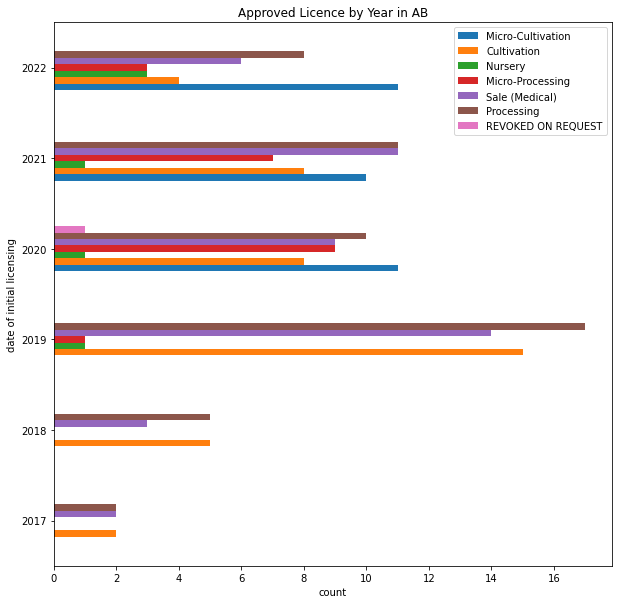

In [111]:
Province_year_grp.loc['AB'].plot(kind='barh', figsize= (10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in AB')


In [95]:
Province_year_grp.loc['ON']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2013,0.0,3,0,0,3,3,0
2014,0.0,7,0,0,6,7,1
2015,0.0,1,0,0,1,1,0
2016,0.0,6,0,0,5,6,0
2017,0.0,17,0,0,13,16,0
2018,0.0,16,0,0,12,22,0
2019,3.0,22,0,2,28,26,0
2020,24.0,31,2,10,34,37,0
2021,28.0,21,2,12,15,25,0


Text(0.5, 1.0, 'Approved Licence by Year in ON')

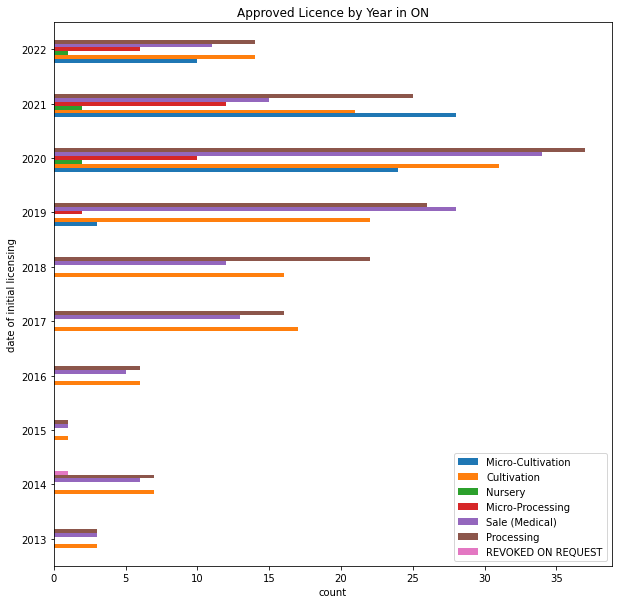

In [103]:
Province_year_grp.loc['ON'].plot(kind= 'barh', figsize=(10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in ON')

In [100]:
Province_year_grp.loc['BC']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2014,0.0,3,0,0,3,3,0
2016,0.0,2,0,0,2,2,0
2017,0.0,7,0,0,7,7,0
2018,1.0,8,0,1,5,7,0
2019,3.0,20,3,1,13,18,0
2020,24.0,25,4,6,19,23,0
2021,30.0,11,7,9,20,16,1
2022,7.0,7,2,5,10,7,0


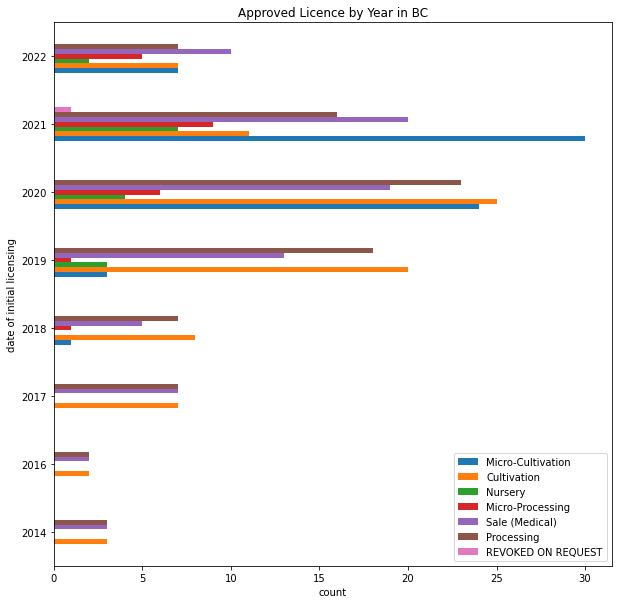

In [120]:
Province_year_grp.loc['BC'].plot(kind= 'barh', figsize=(10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in BC')
plt.legend(loc= 'lower right')

In [112]:
Province_year_grp.loc['MB']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2014,0.0,1,0,0,1,1,0
2020,7.0,1,0,2,3,3,0
2021,1.0,1,0,0,0,2,0
2022,2.0,0,0,1,1,0,0


Text(0.5, 1.0, 'Approved Licence by Year in MB')

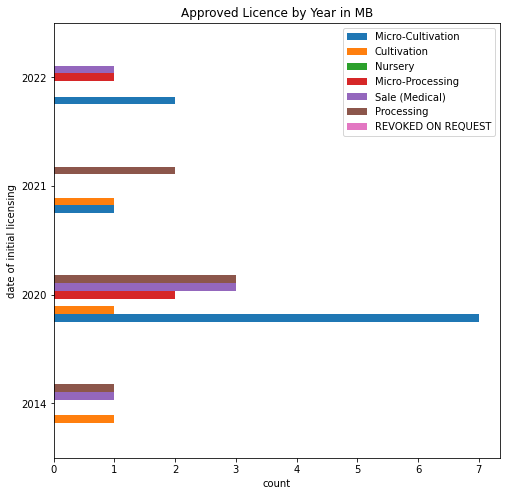

In [121]:
Province_year_grp.loc['MB'].plot(kind= 'barh', figsize=(8,8))
plt.xlabel('count')
plt.title('Approved Licence by Year in MB')

In [113]:
Province_year_grp.loc['NB']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2014,0.0,1,0,0,1,1,0
2017,0.0,1,0,0,1,1,0
2018,0.0,1,0,0,1,1,0
2019,2.0,1,0,1,1,1,0
2020,2.0,4,1,1,3,4,0
2021,5.0,3,0,1,2,1,0
2022,1.0,0,0,0,0,1,0


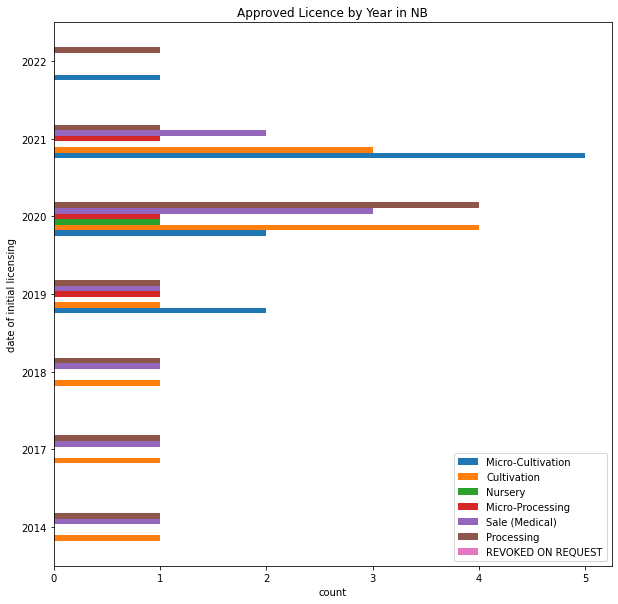

In [123]:
Province_year_grp.loc['NB'].plot(kind= 'barh', figsize=(10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in NB')
plt.legend(loc= 'lower right')

In [114]:
Province_year_grp.loc['NL']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2018,0.0,1,0,0,1,1,0
2019,0.0,1,0,0,1,1,0
2020,3.0,0,0,3,0,0,0
2021,0.0,2,0,0,1,2,0


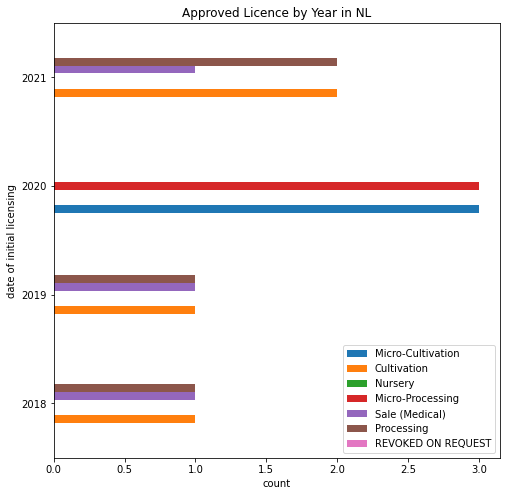

In [165]:
Province_year_grp.loc['NL'].plot(kind= 'barh', figsize=(8,8))
plt.xlabel('count')
plt.title('Approved Licence by Year in NL')
plt.legend(loc= 'lower right')

In [125]:
Province_year_grp.loc['NS']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2017,0.0,2,0,0,2,2,0
2018,0.0,2,0,0,2,2,0
2019,0.0,3,0,0,3,3,1
2020,8.0,2,1,2,2,3,0
2021,11.0,1,0,3,3,0,1
2022,1.0,0,0,0,0,1,0


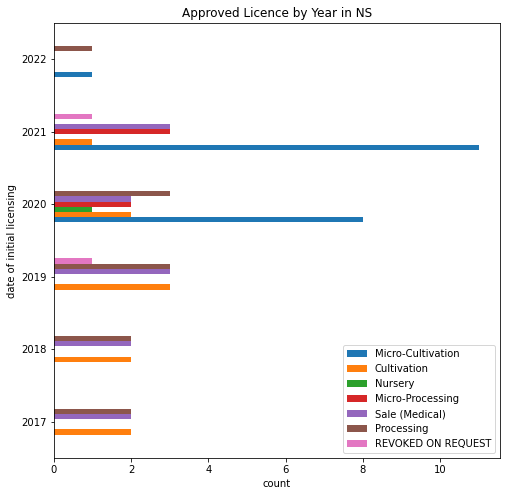

In [166]:
Province_year_grp.loc['NS'].plot(kind= 'barh', figsize=(8,8))
plt.xlabel('count')
plt.title('Approved Licence by Year in NS')
plt.legend(loc= 'lower right')

In [129]:
Province_year_grp.loc['PE']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2016,0.0,1,0,0,1,1,0
2018,0.0,0,0,0,0,1,0
2019,1.0,0,0,0,0,0,0
2020,1.0,0,0,2,0,0,0
2021,0.0,0,0,1,1,2,0
2022,0.0,1,0,0,0,0,0


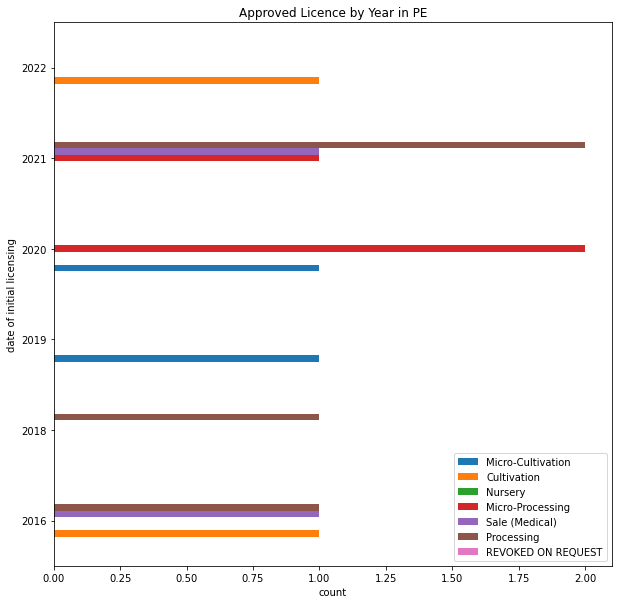

In [132]:
Province_year_grp.loc['PE'].plot(kind= 'barh', figsize=(10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in PE')
plt.legend(loc= 'lower right')

In [128]:
Province_year_grp.loc['QC']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2014,0.0,0,0,0,0,0,1
2017,0.0,2,0,0,0,1,0
2018,0.0,5,0,0,1,4,0
2019,0.0,7,0,2,6,8,0
2020,18.0,28,0,6,22,24,1
2021,17.0,18,1,4,13,15,0
2022,26.0,7,0,5,9,7,0


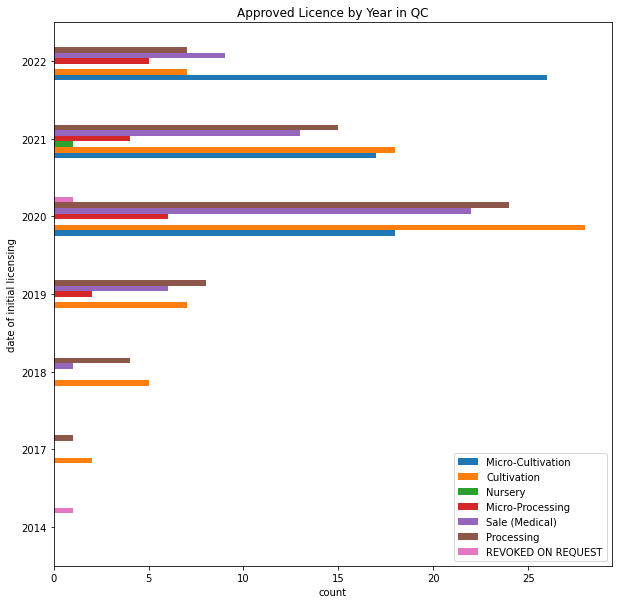

In [131]:
Province_year_grp.loc['QC'].plot(kind= 'barh', figsize=(10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in QC')
plt.legend(loc= 'lower right')

In [127]:
Province_year_grp.loc['SK']

,Micro-Cultivation,Cultivation,Nursery,Micro-Processing,Sale (Medical),Processing,REVOKED ON REQUEST
date of initial licensing,,,,,,,
2017,0.0,1,0,0,1,1,0
2019,2.0,2,1,2,5,4,0
2020,9.0,3,0,5,2,4,0
2021,5.0,3,0,2,0,3,1
2022,2.0,2,0,1,1,2,0


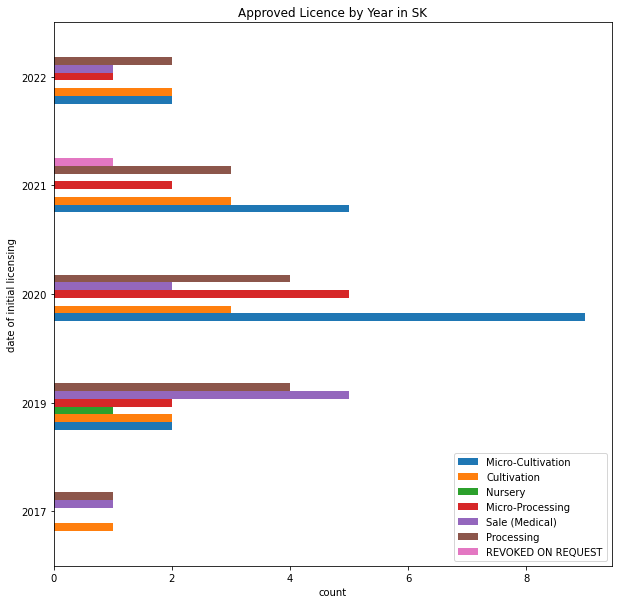

In [130]:
Province_year_grp.loc['SK'].plot(kind= 'barh', figsize=(10,10))
plt.xlabel('count')
plt.title('Approved Licence by Year in SK')
plt.legend(loc= 'lower right')

# How many companies have a particular type of license cannabis by province

In [133]:
#M Medical Cannabis License by Province
medcan_count_byprov=legally_sell_medical.groupby('province / territory')[['Sale (Medical)']].aggregate('count')

In [134]:
medcan_count_by prov

,Sale (Medical)
province / territory,
AB,45
BC,79
MB,5
NB,9
NL,3
NS,12
ON,128
PE,2
QC,51


Text(0.5, 1.0, 'Medical Cannabis License holder by Province')

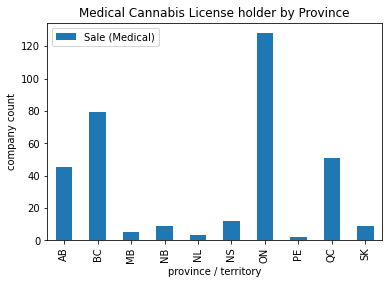

In [110]:
medcan_count_byprov.plot(kind='bar');
plt.ylabel('company count');
plt.title('Medical Cannabis License holder by Province')

In [137]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'Cultivation']
Cultivation_df= merged_licences_df[merged_licences_df['Cultivation']==1][columns]
Cultivation_df.sort_values('province / territory')

,licence holder,province / territory,phone numbers,Cultivation
631,Freedom Cannabis Inc.,AB,1-833-733-3661,1
865,Healius Naturals Ltd,AB,587-984-0747,1
234,2238046 Alberta Ltd.,AB,N/A,1
680,Joi Botanicals Ltd.,AB,N/A,1
663,HTKA GROUP LTD.,AB,1-800-991-4611,1
...,...,...,...,...
810,Under the Sun Groweries Inc.,SK,N/A,1
221,Alinea Cannabis Inc.,SK,N/A,1
835,Western Cannabis Ltd.,SK,N/A,1
808,102021671 Saskatchewan Inc.,SK,N/A,1


In [140]:
Cultivation_count=Cultivation_df.groupby('province / territory')[['Cultivation']].aggregate('count')

In [141]:
Cultivation_count

,Cultivation
province / territory,
AB,42
BC,83
MB,3
NB,11
NL,4
NS,10
NT,1
ON,138
PE,2


Text(0.5, 1.0, 'Cultivation Cannabis License holder by Province')

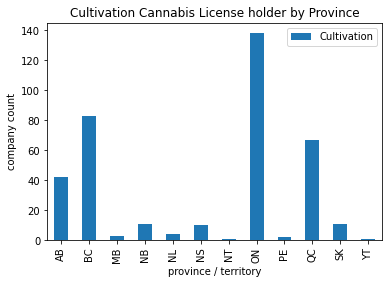

In [142]:
Cultivation_count.plot(kind='bar');
plt.ylabel('company count');
plt.title('Cultivation Cannabis License holder by Province')

In [143]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'Nursery']
Nursery_df= merged_licences_df[merged_licences_df['Nursery']==1][columns]
Nursery_df.sort_values('province / territory')

,licence holder,province / territory,phone numbers,Nursery
671,InPlanta Biotechnology Inc.,AB,N/A,1
59,Black Rock Cannabis Company Ltd.,AB,N/A,1
60,Black Rock Cannabis Company Ltd.,AB,N/A,1
61,Black Rock Cannabis Company Ltd.,AB,N/A,1
349,The Micro Collective Inc.,AB,N/A,1
333,James Edward Carpenter,AB,N/A,1
492,1180192 B.C. LTD. d.b.a. Weathered Islands Cra...,BC,N/A,1
724,NCR Cannabis Corp.,BC,N/A,1
477,1197059 B.C. LTD.,BC,N/A,1
749,ProgenyBio Agricultural Services Inc.,BC,N/A,1


In [144]:
Nursery_count=Nursery_df.groupby('province / territory')[['Nursery']].aggregate('count')

In [145]:
Nursery_count

,Nursery
province / territory,
AB,6
BC,16
NB,1
NS,1
ON,5
QC,1
SK,1


Text(0.5, 1.0, 'Nursery Cannabis License holder by Province')

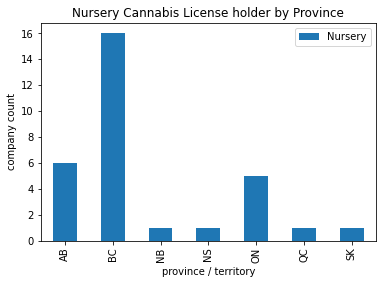

In [146]:
Nursery_count.plot(kind='bar');
plt.ylabel('company count');
plt.title('Nursery Cannabis License holder by Province')

In [149]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'Micro-Cultivation']
Micro_Cultivation_df= merged_licences_df[merged_licences_df['Micro-Cultivation']==1][columns]
Micro_Cultivation_df.sort_values('province / territory')

,licence holder,province / territory,phone numbers,Micro-Cultivation
401,2244102 Alberta Ltd.,AB,N/A,1.0
273,One World Cannabis,AB,N/A,1.0
216,Speclight Ventures Ltd.,AB,N/A,1.0
668,Indigro Organics Inc.,AB,N/A,1.0
46,919 CANNALINE INC.,AB,N/A,1.0
...,...,...,...,...
31,STACKS 306 CRAFT CANNABIS CORP.,SK,N/A,1.0
397,Paradise Cannabis Ltd.,SK,N/A,1.0
402,CanOrganics Inc.,SK,N/A,1.0
325,Pandannis Tree Productions Inc.,SK,N/A,1.0


In [151]:
Micro_Cultivation_count=Micro_Cultivation_df.groupby('province / territory')[['Micro-Cultivation']].aggregate('count')

In [152]:
Micro_Cultivation_count

,Micro-Cultivation
province / territory,
AB,32
BC,65
MB,10
NB,10
NL,3
NS,20
ON,65
PE,2
QC,61


Text(0.5, 1.0, 'Micro-Cultivation Cannabis License holder by Province')

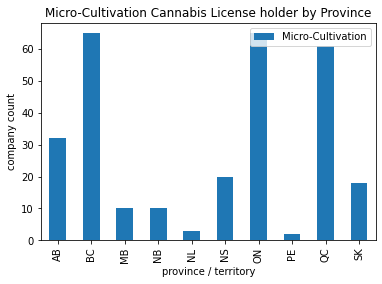

In [167]:
Micro_Cultivation_count.plot(kind='bar');
plt.ylabel('company count');
plt.title('Micro-Cultivation Cannabis License holder by Province')

In [156]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'Processing']
Processing_df= merged_licences_df[merged_licences_df['Processing']==1][columns]
Processing_df.sort_values('province / territory')

,licence holder,province / territory,phone numbers,Processing
557,Aurora Cannabis Enterprises Inc.\r\n (3rd...,AB,1-844-9AURORA\r\n (928-7672),1
496,1800905 Alberta Ltd. d.b.a. sugarbud,AB,N/A,1
836,Westleaf Labs LP,AB,N/A,1
147,Alternative Farming Solutions Inc.,AB,N/A,1
903,Simply Solventless Concentrates Ltd.,AB,1-833-772-4274,1
...,...,...,...,...
737,OneLeaf Cannabis Corp.,SK,N/A,1
841,Zyus Life Sciences Inc.,SK,1-833-713-CARE (2273),1
76,Cosmic Extracts Inc.,SK,N/A,1
622,ENDLESS SKY INC.,SK,403-978-3965,1


In [160]:
Processing_count=Processing_df.groupby('province / territory')[['Processing']].aggregate('count')

In [161]:
Processing_count

,Processing
province / territory,
AB,53
BC,83
MB,6
NB,10
NL,4
NS,11
NT,1
ON,157
PE,4


Text(0.5, 1.0, 'Processing Cannabis License holder by Province')

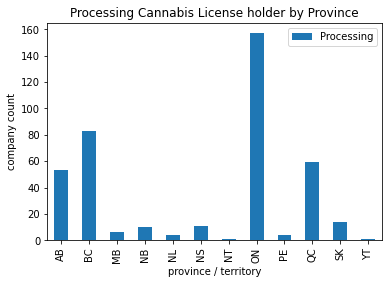

In [163]:
Processing_count.plot(kind='bar');
plt.ylabel('company count');
plt.title('Processing Cannabis License holder by Province')

In [155]:
columns = ['licence holder', 'province / territory', 'phone numbers' , 'Micro-Processing']
Micro_Processing_df= merged_licences_df[merged_licences_df['Micro-Processing']==1][columns]
Micro_Processing_df.sort_values('province / territory')

,licence holder,province / territory,phone numbers,Micro-Processing
421,Supernova Farms Inc.,AB,N/A,1
207,Craft Botanicals Ltd.,AB,N/A,1
222,Zelca Ltd.,AB,N/A,1
419,Alberta Bud Inc.,AB,N/A,1
670,iNaturally Organic Inc.,AB,N/A,1
...,...,...,...,...
271,102002643 SASKATCHEWAN LTD. d.b.a. Fisher Fami...,SK,N/A,1
253,Sparkle Country Garden,SK,N/A,1
777,Southern Prairie Plant Growers Ltd. d.b.a T8 C...,SK,N/A,1
730,North 40 Cannabis Limited,SK,N/A,1


In [158]:
Micro_Processing_count=Micro_Processing_df.groupby('province / territory')[['Micro-Processing']].aggregate('count')

In [162]:
Micro_Processing_count

,Micro-Processing
province / territory,
AB,20
BC,22
MB,3
NB,3
NL,3
NS,5
ON,30
PE,3
QC,17


Text(0.5, 1.0, 'Micro_Processing Cannabis License holder by Province')

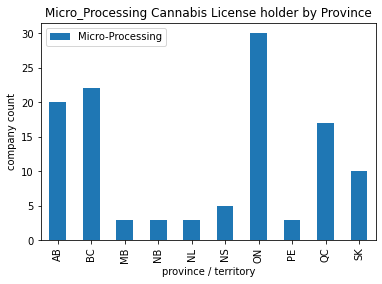

In [164]:
Micro_Processing_count.plot(kind='bar');
plt.ylabel('company count');
plt.title('Micro_Processing Cannabis License holder by Province')